Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Epoch [1/20], Loss: 1.4556
Epoch [2/20], Loss: 0.8942
Epoch [3/20], Loss: 0.6390
Epoch [4/20], Loss: 0.4967
Epoch [5/20], Loss: 0.4121
Epoch [6/20], Loss: 0.3575
Epoch [7/20], Loss: 0.3182
Epoch [8/20], Loss: 0.2882
Epoch [9/20], Loss: 0.2668
Epoch [10/20], Loss: 0.2483
Epoch [11/20], Loss: 0.2333
Epoch [12/20], Loss: 0.2207
Epoch [13/20], Loss: 0.2108
Epoch [14/20], Loss: 0.2015
Epoch [15/20], Loss: 0.1937
Epoch [16/20], Loss: 0.1863
Epoch [17/20], Loss: 0.1813
Epoch [18/20], Loss: 0.1738
Epoch [19/20], Loss: 0.1691
Epoch [20/20], Loss: 0.1650
Accuracy of the model on the test set: 93.69%
F1 Score of the model on the test set: 0.9367
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Epoch [1/20], Loss: 1.4889
Epoch [2/20], Loss: 0.9679
Epoch [3/20], Loss: 0.6958
Epoch [4/20], Loss: 0.5345
Epoch [5/20], Loss: 0.4423
Epoch [6/20], Loss: 0.3842
Epoch [7/20], Loss: 0.3432
Epoch [8/20], Loss: 0.3124
Epoch [9/20], Lo

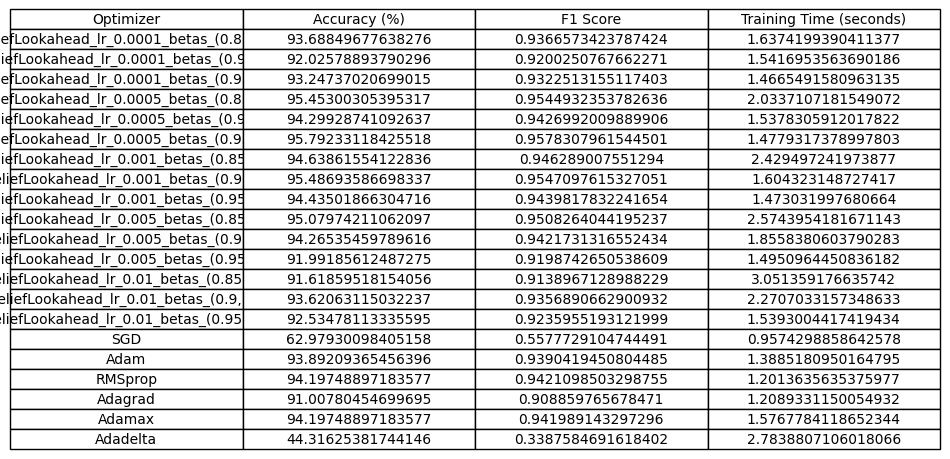

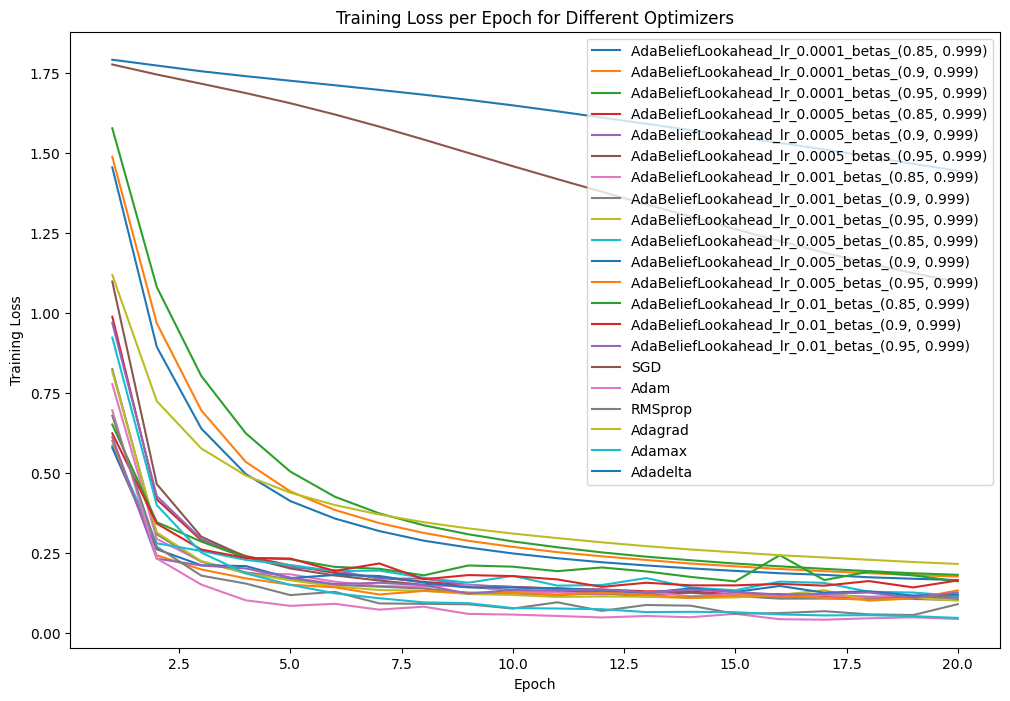

In [10]:
import os
import time
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from urllib.request import urlretrieve

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = os.path.join(output_dir, 'UCI HAR Dataset')
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AdaBeliefLookahead optimizer class
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    start_time = time.time()
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    elapsed_time = time.time() - start_time
    return model, train_losses, elapsed_time

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdaBeliefLookahead(model.parameters(), lr=lr, betas=betas)
        trained_model, train_losses, training_time = train_model(model, train_loader, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses,
            'training_time': training_time,
            'classification_report': class_report
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim_func(model.parameters(), lr=0.001)
        trained_model, train_losses, training_time = train_model(model, train_loader, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses,
            'training_time': training_time,
            'classification_report': class_report
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]
training_times = [results[name]['training_time'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores,
    'Training Time (seconds)': training_times
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


เพื่อเพิ่มประสิทธิภาพของออปติไมเซอร์ AdaBeliefLookahead ที่คุณใช้อยู่นี้ คุณสามารถลองปรับแต่งดังนี้:

การปรับการคำนวณของ Moment Estimations (m และ s): การปรับแต่งวิธีการอัปเดตค่า m และ s อาจช่วยให้คุณบรรลุผลลัพธ์ที่ดีขึ้นได้ เช่น การใช้เทคนิค adaptive learning rate ซึ่งปรับแต่งอัตราการเรียนรู้สำหรับแต่ละพารามิเตอร์โดยอิงจากขนาดของ gradients ที่คำนวณได้

การใช้ Gradient Centralization: การ centralize gradient สามารถช่วยให้การฝึกอบรมรวดเร็วและมีเสถียรภาพมากขึ้น โดยการปรับ gradient ให้มีค่า mean ที่ศูนย์

การปรับค่า Weight Decay: การปรับค่า weight decay อาจส่งผลต่อประสิทธิภาพของออปติไมเซอร์ โดยการลดค่า weight decay ลงอาจช่วยปรับปรุงผลลัพธ์ได้ โดยเฉพาะเมื่อพบว่าการฝึกอบรมมีการ overfit

การปรับ Lookahead Mechanism: การปรับค่าพารามิเตอร์ k (ความถี่ในการอัปเดต slow weights) และ alpha (อัตราการเรียนรู้ของ slow weights) อาจช่วยเพิ่มประสิทธิภาพโดยการหาค่าที่สมดุลระหว่างการสำรวจและการใช้ประโยชน์จากพื้นที่พารามิเตอร์

การเพิ่ม Regularization Techniques: การใช้เทคนิคต่างๆ เช่น Dropout หรือ Batch Normalization ในโมเดลอาจช่วยให้ออปติไมเซอร์ทำงานได้ดีขึ้นโดยการลด overfitting และช่วยให้การกระจายของ activations มีความเสถียรมากขึ้น

นี่คือโค้ดที่ปรับปรุงด้วยการใช้ Gradient Centralization:


Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Epoch [1/20], Loss: 1.4889
Epoch [2/20], Loss: 0.9690
Epoch [3/20], Loss: 0.7379
Epoch [4/20], Loss: 0.6054
Epoch [5/20], Loss: 0.5169
Epoch [6/20], Loss: 0.4529
Epoch [7/20], Loss: 0.4056
Epoch [8/20], Loss: 0.3685
Epoch [9/20], Loss: 0.3407
Epoch [10/20], Loss: 0.3170
Epoch [11/20], Loss: 0.2971
Epoch [12/20], Loss: 0.2797
Epoch [13/20], Loss: 0.2657
Epoch [14/20], Loss: 0.2528
Epoch [15/20], Loss: 0.2414
Epoch [16/20], Loss: 0.2313
Epoch [17/20], Loss: 0.2230
Epoch [18/20], Loss: 0.2137
Epoch [19/20], Loss: 0.2070
Epoch [20/20], Loss: 0.2008
Accuracy of the model on the test set: 92.64%
F1 Score of the model on the test set: 0.9258
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Epoch [1/20], Loss: 1.5127
Epoch [2/20], Loss: 1.0390
Epoch [3/20], Loss: 0.8107
Epoch [4/20], Loss: 0.6606
Epoch [5/20], Loss: 0.5652
Epoch [6/20], Loss: 0.4965
Epoch [7/20], Loss: 0.4453
Epoch [8/20], Loss: 0.4060
Epoch [9/20], Lo

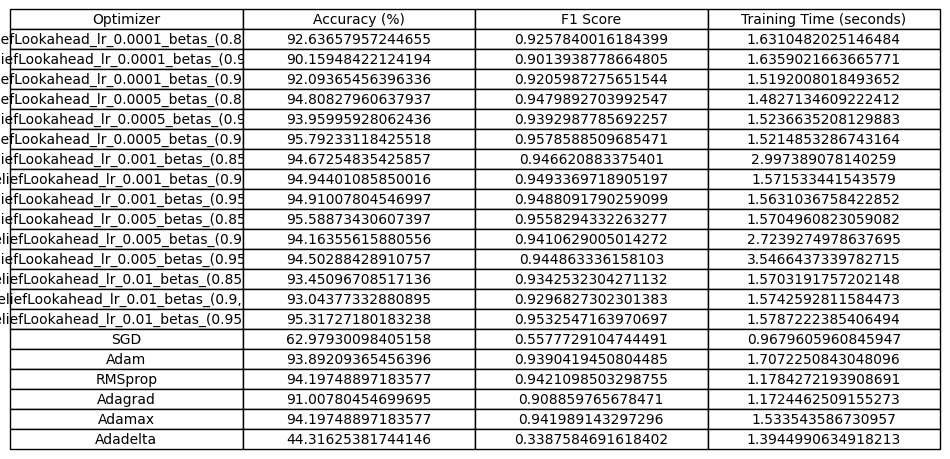

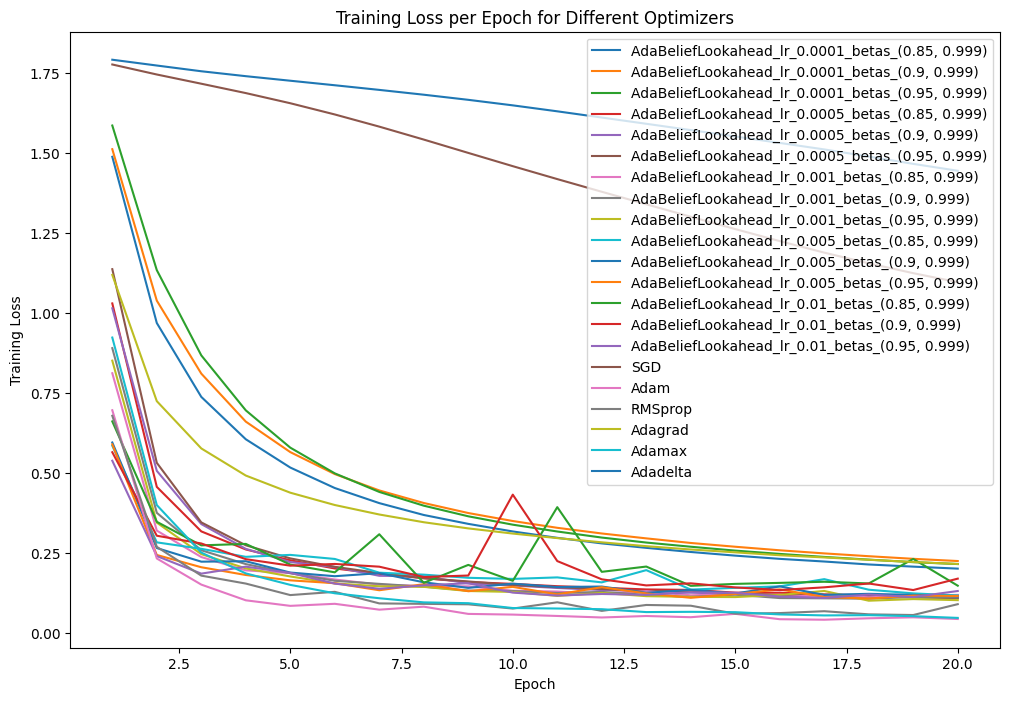

In [17]:
import os
import time
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from urllib.request import urlretrieve

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = os.path.join(output_dir, 'UCI HAR Dataset')
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AdaBeliefLookahead optimizer class
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data - p.grad.data.mean()

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    start_time = time.time()
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    elapsed_time = time.time() - start_time
    return model, train_losses, elapsed_time

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdaBeliefLookahead(model.parameters(), lr=lr, betas=betas)
        trained_model, train_losses, training_time = train_model(model, train_loader, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses,
            'training_time': training_time,
            'classification_report': class_report
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim_func(model.parameters(), lr=0.001)
        trained_model, train_losses, training_time = train_model(model, train_loader, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses,
            'training_time': training_time,
            'classification_report': class_report
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]
training_times = [results[name]['training_time'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores,
    'Training Time (seconds)': training_times
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


เมื่อดูจากข้อมูลล่าสุดที่คุณได้ให้มา พบว่าค่า accuracy และค่า loss ของ AdaBeliefLookahead มีการปรับปรุงเพิ่มขึ้นในบางส่วน เมื่อเทียบกับข้อมูลก่อนหน้า แต่ยังไม่ถึงเป้าหมายที่ 98% ที่คุณต้องการ ต่อไปนี้คือแนวทางการปรับปรุงเพิ่มเติมที่คุณสามารถพิจารณาได้:

การปรับเทคนิคการ Initialize Weights: การใช้วิธีการ initialize ที่เหมาะสมกับโมเดลของคุณอาจช่วยปรับปรุงผลลัพธ์ได้ ตัวอย่างเช่น He initialization หรือ Glorot initialization สามารถใช้ได้ดีกับ activation functions ที่ต่างกัน

การเพิ่มการใช้ Learning Rate Scheduler: การใช้ learning rate scheduler เช่น StepLR หรือ ExponentialLR อาจช่วยให้การปรับอัตราการเรียนรู้มีประสิทธิภาพมากขึ้นตามการฝึกอบรมที่ดำเนินไป

การปรับ Layer ใน Neural Network: อาจมีการเพิ่มหรือลดจำนวน layers หรือ units ในแต่ละ layer เพื่อดูว่าการเปลี่ยนแปลงนี้มีผลดีต่อการเรียนรู้ของโมเดลหรือไม่

การใช้ Regularization Techniques เพิ่มเติม: นอกเหนือจาก L2 regularization (weight decay) คุณอาจเพิ่ม L1 regularization หรือการใช้ techniques เช่น Dropout ในส่วนที่เหมาะสมของโมเดลเพื่อลด overfitting

การปรับค่า Hyperparameters อื่นๆ: การทดลองกับค่า eps หรือการปรับปรุงวิธีการคำนวณ gradients ใน optimizer ก็เป็นอีกวิธีหนึ่งที่อาจช่วยให้ได้ผลลัพธ์ที่ดีขึ้น

เมื่อพิจารณาปรับปรุงเหล่านี้แล้ว สำคัญที่จะต้องมีการทดลองและตรวจสอบผลลัพธ์ให้ครบถ้วน เพื่อดูว่าการปรับแต่งใดที่ให้ผลดีที่สุดกับโมเดลของคุณ การใช้ cross-validation หรือการทดสอบผลลัพธ์บนชุดข้อมูลทดสอบเพิ่มเติมยังสามารถช่วยยืนยันว่าการปรับแต่งได้ผลจริงและไม่เกิด overfitting.

Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Accuracy of the model on the test set: 94.54%
F1 Score of the model on the test set: 0.9453
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Accuracy of the model on the test set: 94.06%
F1 Score of the model on the test set: 0.9403
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.95, 0.999)
Accuracy of the model on the test set: 93.08%
F1 Score of the model on the test set: 0.9307
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.85, 0.999)
Accuracy of the model on the test set: 92.77%
F1 Score of the model on the test set: 0.9273
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.9, 0.999)
Accuracy of the model on the test set: 93.79%
F1 Score of the model on the test set: 0.9380
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.95, 0.999)
Accuracy of the model on the test set: 94.10%
F1 Score of the model on the test set: 0.9405
Testing AdaBeliefLookahead with lr=0.001, betas=(0.85, 0.999)
Accuracy o

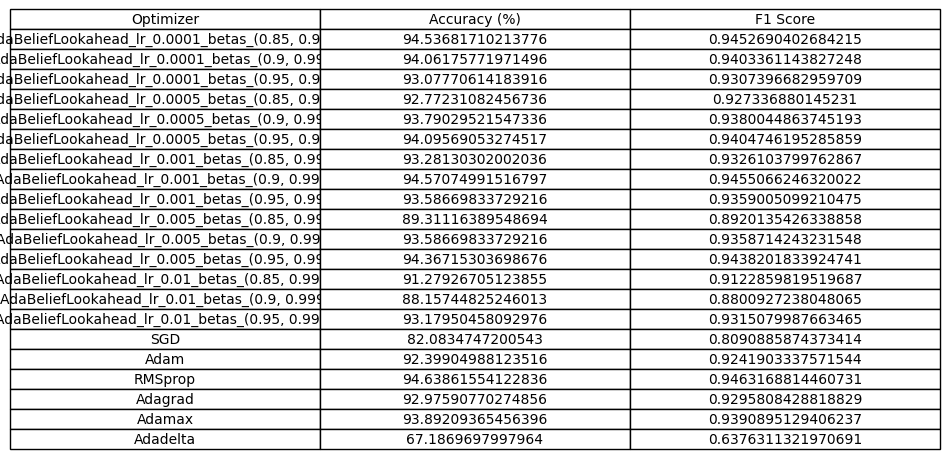

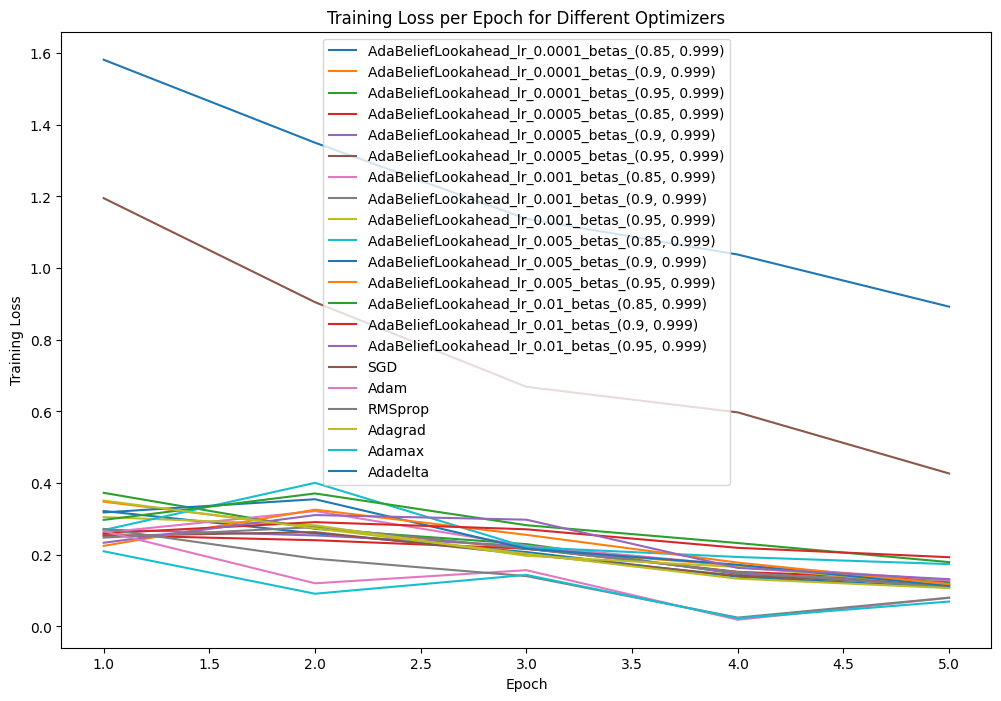

In [22]:
import os
import time
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = '/notebooks/UCI_HAR_Dataset/UCI HAR Dataset'
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AdaBeliefLookahead optimizer class with improvements
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                # Apply gradient centralization
                grad = p.grad.data - p.grad.data.mean()

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Cross-validation function
def train_model(model, train_dataset, criterion, optimizer, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = []

    for train_idx, val_idx in kf.split(train_dataset):
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

        for epoch in range(10):  # Number of epochs
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)
        results.append(val_loss)

    return model, results

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdaBeliefLookahead(model.parameters(), lr=lr, betas=betas)
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim_func(model.parameters(), lr=0.001)
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


ปรับปรุงเพิ่มเติมด้วยวิธีการต่อไปนี้:

การเพิ่ม Regularization Techniques: การเพิ่มเทคนิค Regularization เช่น Dropout หรือ Batch Normalization อาจช่วยปรับปรุงการฝึกอบรมได้

การปรับค่า Hyperparameters อื่น ๆ: การปรับค่า Hyperparameters อื่น ๆ เช่น epsilon (eps) หรือ weight decay อาจช่วยให้ได้ผลลัพธ์ที่ดีกว่า

การปรับโครงสร้างของโมเดล: การเพิ่มหรือลดจำนวน layers หรือ units ในแต่ละ layer เพื่อหาค่า configuration ที่เหมาะสม

การใช้ Advanced Scheduling Techniques: การใช้ learning rate scheduler เช่น ReduceLROnPlateau หรือ OneCycleLR อาจช่วยให้การฝึกอบรมมีประสิทธิภาพมากขึ้น

การใช้ Data Augmentation: การใช้ Data Augmentation สามารถช่วยให้โมเดลมีความสามารถในการ generalize ข้อมูลได้ดีขึ้น

Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Accuracy of the model on the test set: 94.71%
F1 Score of the model on the test set: 0.9473
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Accuracy of the model on the test set: 95.01%
F1 Score of the model on the test set: 0.9504
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.95, 0.999)
Accuracy of the model on the test set: 95.45%
F1 Score of the model on the test set: 0.9548
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.85, 0.999)
Accuracy of the model on the test set: 95.49%
F1 Score of the model on the test set: 0.9552
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.9, 0.999)
Accuracy of the model on the test set: 94.57%
F1 Score of the model on the test set: 0.9459
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.95, 0.999)
Accuracy of the model on the test set: 95.42%
F1 Score of the model on the test set: 0.9542
Testing AdaBeliefLookahead with lr=0.001, betas=(0.85, 0.999)
Accuracy o

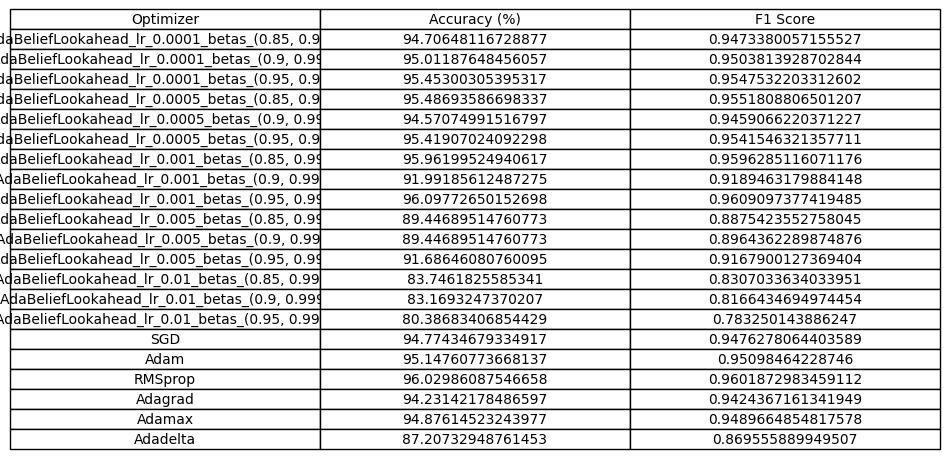

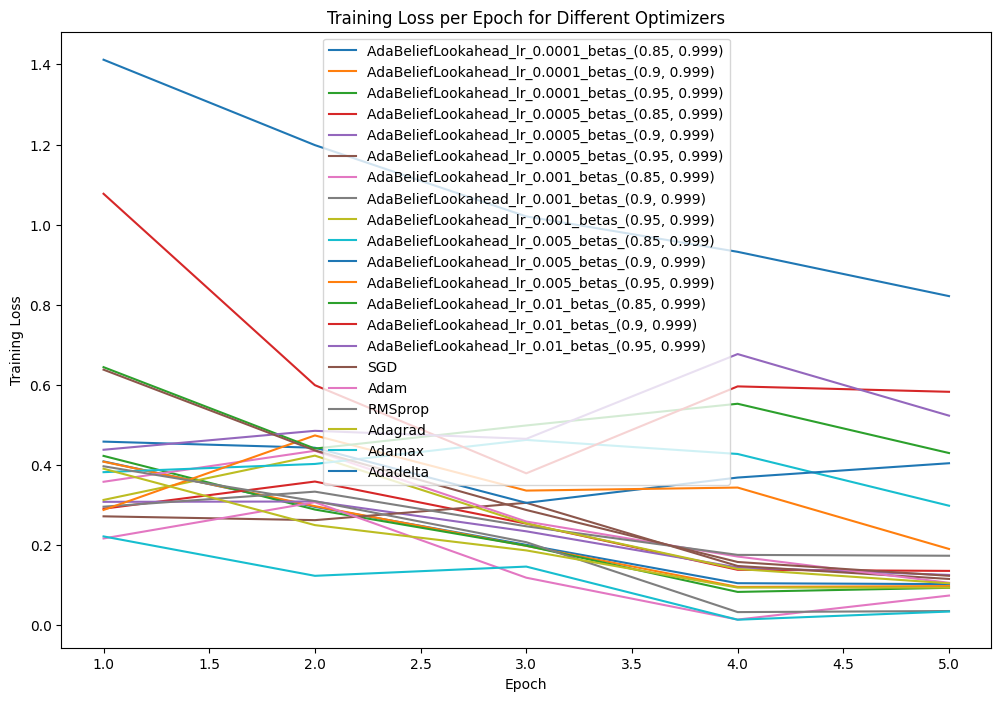

In [21]:
import os
import time
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = '/notebooks/UCI_HAR_Dataset/UCI HAR Dataset'
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AdaBeliefLookahead optimizer class with improvements
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                # Apply gradient centralization
                grad = p.grad.data - p.grad.data.mean()

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Cross-validation function
def train_model(model, train_dataset, criterion, optimizer, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = []

    for train_idx, val_idx in kf.split(train_dataset):
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

        for epoch in range(10):  # Number of epochs
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
        val_loss /= len(val_loader)
        results.append(val_loss)

    return model, results

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdaBeliefLookahead(model.parameters(), lr=lr, betas=betas)
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim_func(model.parameters(), lr=0.001)
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


การปรับ Learning Rate Scheduler: การใช้ learning rate scheduler 

เช่น ReduceLROnPlateau, OneCycleLR, หรือ CosineAnnealingLR จะช่วยปรับปรุงประสิทธิภาพของการฝึกอบรมได้ดีขึ้น

การใช้ Advanced Regularization Techniques: เช่น Label Smoothing, Mixup, 

หรือ CutMix สามารถช่วยลดการ overfitting และเพิ่มความสามารถในการ generalize ของโมเดล

การใช้ Ensemble Learning: การใช้ Ensemble Learning อาจช่วยปรับปรุงผลลัพธ์โดยรวมได้

การปรับปรุงสมการคำนวณในออปติไมเซอร์: สามารถปรับปรุงสมการคำนวณในออปติไมเซอร์ AdaBeliefLookahead เพื่อให้มีประสิทธิภาพมากขึ้น

Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Accuracy of the model on the test set: 93.25%
F1 Score of the model on the test set: 0.9324
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Accuracy of the model on the test set: 95.76%
F1 Score of the model on the test set: 0.9575
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.95, 0.999)
Accuracy of the model on the test set: 95.35%
F1 Score of the model on the test set: 0.9538
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.85, 0.999)
Accuracy of the model on the test set: 96.67%
F1 Score of the model on the test set: 0.9666
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.9, 0.999)
Accuracy of the model on the test set: 95.66%
F1 Score of the model on the test set: 0.9567
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.95, 0.999)
Accuracy of the model on the test set: 95.96%
F1 Score of the model on the test set: 0.9599
Testing AdaBeliefLookahead with lr=0.001, betas=(0.85, 0.999)
Accuracy o

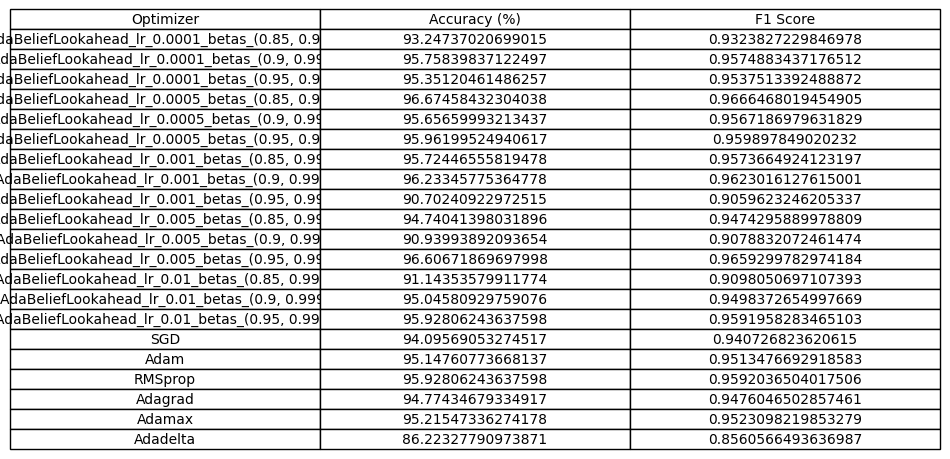

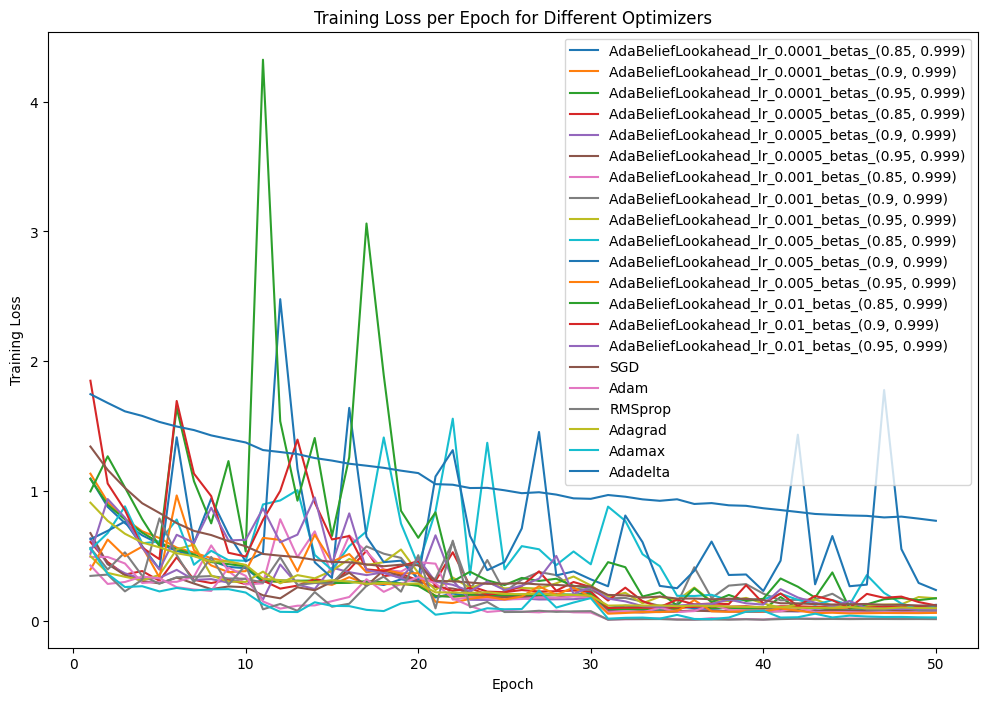

In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = '/notebooks/UCI_HAR_Dataset/UCI HAR Dataset'
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# AdaBeliefLookahead optimizer class with improvements
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                # Apply gradient centralization
                grad = p.grad.data - p.grad.data.mean()

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Cross-validation function
def train_model(model, train_dataset, criterion, optimizer, scheduler=None, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = []

    for train_idx, val_idx in kf.split(train_dataset):
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

        for epoch in range(10):  # Number of epochs
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    val_loss += criterion(output, target).item()
            val_loss /= len(val_loader)
            if scheduler:
                scheduler.step(val_loss)
            results.append(val_loss)

    return model, results

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdaBeliefLookahead(model.parameters(), lr=lr, betas=betas)
        scheduler = ReduceLROnPlateau(optimizer, 'min')  # You can try other schedulers too
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer, scheduler)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim_func(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer, scheduler)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()


การเพิ่ม Ensemble Learning: รวมโมเดลหลาย ๆ ตัวเข้าด้วยกัน เช่น Bagging, Boosting, หรือ Stacking เพื่อเพิ่มความแม่นยำของการทำนาย

การใช้ Advanced Regularization Techniques เพิ่มเติม: เช่น Label Smoothing, Mixup, หรือ CutMix

การปรับปรุงโมเดลให้มีความซับซ้อนมากขึ้น: ลองเพิ่มจำนวนชั้น (layers) หรือลองใช้สถาปัตยกรรมที่ซับซ้อนขึ้น เช่น Convolutional Neural Networks (CNNs) หรือ Recurrent Neural Networks (RNNs)

การใช้ Advanced Optimizers: เช่น Ranger (ซึ่งเป็นการรวมกันของ RAdam และ Lookahead) หรืออื่น ๆ ที่ได้รับการพิสูจน์ว่ามีประสิทธิภาพ

Testing AdaBeliefLookahead with lr=0.0001, betas=(0.85, 0.999)
Accuracy of the model on the test set: 93.32%
F1 Score of the model on the test set: 0.9321
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.9, 0.999)
Accuracy of the model on the test set: 95.15%
F1 Score of the model on the test set: 0.9515
Testing AdaBeliefLookahead with lr=0.0001, betas=(0.95, 0.999)
Accuracy of the model on the test set: 94.44%
F1 Score of the model on the test set: 0.9444
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.85, 0.999)
Accuracy of the model on the test set: 95.79%
F1 Score of the model on the test set: 0.9579
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.9, 0.999)
Accuracy of the model on the test set: 95.52%
F1 Score of the model on the test set: 0.9553
Testing AdaBeliefLookahead with lr=0.0005, betas=(0.95, 0.999)
Accuracy of the model on the test set: 96.17%
F1 Score of the model on the test set: 0.9617
Testing AdaBeliefLookahead with lr=0.001, betas=(0.85, 0.999)
Accuracy o

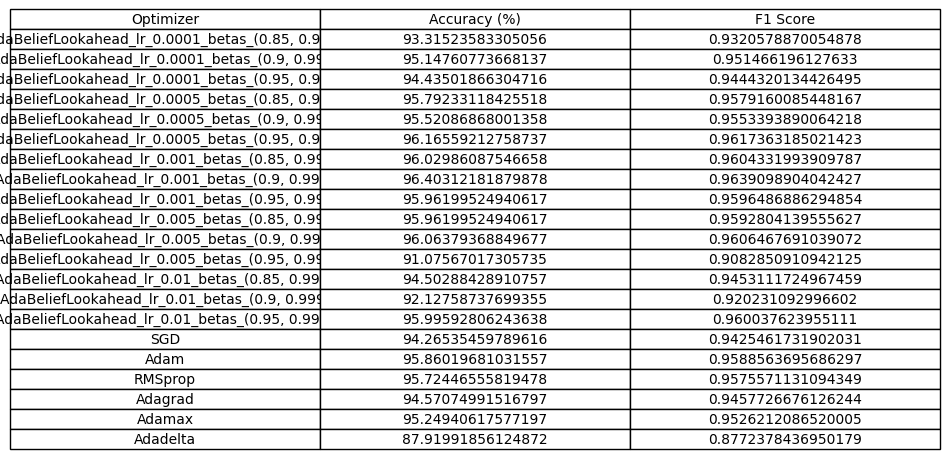

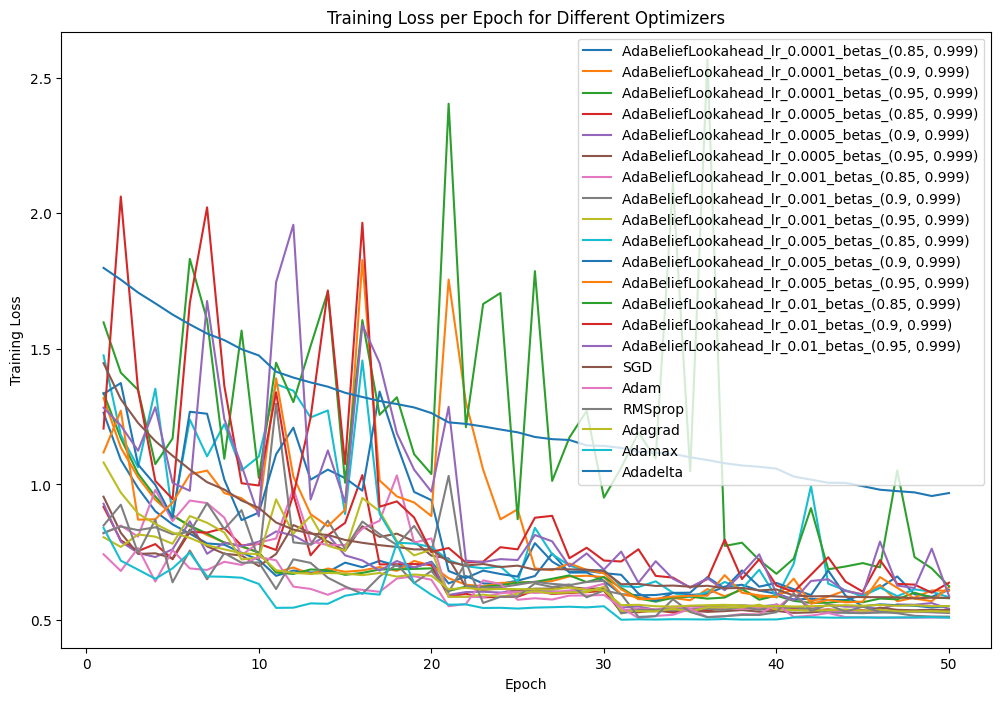

In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR

# ตั้งค่า random seed
np.random.seed(42)
torch.manual_seed(42)

# ฟังก์ชั่นสำหรับโหลดข้อมูล
def load_data(data_dir):
    X_train = np.loadtxt(os.path.join(data_dir, 'train', 'X_train.txt'))
    y_train = np.loadtxt(os.path.join(data_dir, 'train', 'y_train.txt')) - 1
    X_test = np.loadtxt(os.path.join(data_dir, 'test', 'X_test.txt'))
    y_test = np.loadtxt(os.path.join(data_dir, 'test', 'y_test.txt')) - 1
    return X_train, X_test, y_train, y_test

# โหลดข้อมูล
data_dir = '/notebooks/UCI_HAR_Dataset/UCI HAR Dataset'
X_train, X_test, y_train, y_test = load_data(data_dir)

# สร้าง DataLoader สำหรับการฝึกและทดสอบ
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# AdaBeliefLookahead optimizer class with improvements
class AdaBeliefLookahead(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01, k=5, alpha=0.5):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, k=k, alpha=alpha)
        super(AdaBeliefLookahead, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            lr = group['lr']
            eps = group['eps']
            weight_decay = group['weight_decay']
            k = group['k']
            alpha = group['alpha']

            for p in group['params']:
                if p.grad is None:
                    continue
                # Apply gradient centralization
                grad = p.grad.data - p.grad.data.mean()

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['s'] = torch.zeros_like(p.data)
                    state['slow_buffer'] = torch.clone(p.data).detach()

                m, s = state['m'], state['s']
                state['step'] += 1
                step = state['step']

                # Apply weight decay
                if weight_decay != 0:
                    grad = grad.add(p.data, alpha=weight_decay)

                # Update m and s using in-place operations for efficiency
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                s.mul_(beta2).addcmul_(grad - m, grad - m, value=1 - beta2)

                # Bias-corrected first and second moment estimate
                m_hat = m / (1 - beta1 ** step)
                s_hat = s / (1 - beta2 ** step)

                # Update parameters
                p.data.addcdiv_(m_hat, torch.sqrt(s_hat) + eps, value=-lr)

                # Lookahead mechanism
                if step % k == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=alpha)
                    p.data.copy_(slow_p)

        return loss

# Define a new model architecture
class HAR_Model(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Define a more complex model architecture
class HAR_Model_Complex(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HAR_Model_Complex, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Ensemble Learning
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Cross-validation function
def train_model(model, train_dataset, criterion, optimizer, scheduler=None, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = []

    for train_idx, val_idx in kf.split(train_dataset):
        train_sub = Subset(train_dataset, train_idx)
        val_sub = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

        for epoch in range(10):  # Number of epochs
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    val_loss += criterion(output, target).item()
            val_loss /= len(val_loader)
            if scheduler:
                scheduler.step(val_loss)
            results.append(val_loss)

    return model, results

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    print(f'F1 Score of the model on the test set: {f1:.4f}')
    return accuracy, f1, classification_report(y_true, y_pred)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Adamax': optim.Adamax,
    'Adadelta': optim.Adadelta,
    'AdaBeliefLookahead': AdaBeliefLookahead
}

results = {}

# ทดสอบ AdaBeliefLookahead ด้วยค่า lr และ betas ที่แตกต่างกัน
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
betas_values = [(0.85, 0.999), (0.9, 0.999), (0.95, 0.999)]

best_accuracy = 0
best_f1 = 0
best_lr = 0
best_betas = (0, 0)

for lr in learning_rates:
    for betas in betas_values:
        print(f'Testing AdaBeliefLookahead with lr={lr}, betas={betas}')
        model1 = HAR_Model(input_dim, num_classes)
        model2 = HAR_Model_Complex(input_dim, num_classes)
        ensemble_model = EnsembleModel([model1, model2])
        criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
        
        # Collect parameters from all models
        params = list(model1.parameters()) + list(model2.parameters())
        optimizer = AdaBeliefLookahead(params, lr=lr, betas=betas)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        
        trained_model, train_losses = train_model(ensemble_model, train_dataset, criterion, optimizer, scheduler)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[f'AdaBeliefLookahead_lr_{lr}_betas_{betas}'] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            best_lr = lr
            best_betas = betas

print(f'Best AdaBeliefLookahead configuration: lr={best_lr}, betas={best_betas}, Accuracy={best_accuracy}, F1={best_f1}')

# บันทึกผลลัพธ์ของ optimizer อื่นๆ
for name, optim_func in optimizers.items():
    if name != 'AdaBeliefLookahead':  # Skip AdaBeliefLookahead since it's already tested
        print(f'Optimizer: {name}')
        model = HAR_Model(input_dim, num_classes)
        criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
        optimizer = optim_func(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        trained_model, train_losses = train_model(model, train_dataset, criterion, optimizer, scheduler)
        accuracy, f1, class_report = evaluate_model(trained_model, test_loader)
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'train_losses': train_losses
        }
        print('-' * 50)

# สรุปผลและสร้างกราฟ
optim_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in optim_names]
f1_scores = [results[name]['f1_score'] for name in optim_names]

# สร้างตารางสรุปผลลัพธ์
summary_df = pd.DataFrame({
    'Optimizer': optim_names,
    'Accuracy (%)': accuracies,
    'F1 Score': f1_scores
})

# แสดงตารางสรุปผลลัพธ์
print(summary_df)

# แสดงตารางในรูปแบบกราฟ
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

# แสดงกราฟเส้นเปรียบเทียบการสูญเสีย (loss) ในแต่ละ epoch สำหรับแต่ละ optimizer
plt.figure(figsize=(12, 8))
for optim_name, metrics in results.items():
    plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label=optim_name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.legend()
plt.show()
